# Xây dựng mô hình học máy dự đoán giá xe máy

<center>
    <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSCPoABnVguHOm4kEvQhjKlJkX0AGZMur6LSg&usqp=CAU">
</center>

Sau khi đã trải qua các bước, từ việc chuẩn bị dữ liệu, làm sạch, đưa ra những sự phân tích, đánh giá cơ bản, thì bây giờ chúng ta sẽ đến với bước quan trọng nhất, cũng chính là bước chính thức của dự án này, đó là chúng ta sẽ xây dựng một mô hình dự đoán giá xe máy, có sự đánh giá, lựa chọn ra mô hình tốt nhất trước khi chúng ta đưa vào hệ thống sản phẩm (có giao diện website).

Bài toán lần này là một bài toán về hồi quy, dựa đoán giá trị thực của một thuộc tính, do đó chúng ta cần chọn ra những công cụ, những thuật toán phù hợp để xây dựng tốt mô hình.

Trong dự án này, sẽ sử dụng các công cụ hồi quy đang được hướng dẫn căn bản từ khóa học Machine Learning Specialization của công ty DeepLearning.AI, bao gồm Hồi quy tuyến tính (Linear Regression) (Không chỉ gồm hồi quy tuyến tính mà còn có thể sử dụng tới hồi quy đa thức (Polynomial Regression) - một biến thể của hồi quy tuyến tính, Kỹ thuật hiệu chỉnh thông qua Ridge Regression), Rừng ngẫu nhiên (Random Forest) và Mạng Neural với hàm kích hoạt ở lớp (layer) cuối cùng là hàm tuyến tính (linear-activation). 

## 0. Khai báo các thư viện, framework cần thiết


In [454]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


import pickle

#  Các biến đường dẫn được thay đổi tùy thuộc vào local
PATH = r"/home/duyanh/Documents/VS_WorkSpace/projects/programming_for_DS_v1/data/moto_cleaned_EDA.csv"

SAVE_PATH = r'/home/duyanh/Documents/VS_WorkSpace/projects/programming_for_DS_v1/model/model.pkl'

In [455]:
df = pd.read_csv(PATH)
print(f'Số chiều: {df.shape}')
df.head(10)

Số chiều: (11119, 9)


,Hang_xe,Tuoi_xe,Nam_dang_ky,Tinh_trang_xe,Dung_tich_xe,Dong_xe,So_km_da_di,Loai_xe,Gia_xe
0,Suzuki,27,1996,Đã sử dụng,Không rõ,Sport/Xipo,1234,Tay côn,25500000.0
1,Piaggio,9,2014,Đã sử dụng,100 - 175 cc,Vespa,11000,Tay ga,32500000.0
2,Yamaha,10,2013,Đã sử dụng,100 - 175 cc,Exciter,25,Tay côn,27500000.0
3,Yamaha,8,2015,Đã sử dụng,100 - 175 cc,Exciter,37,Xe số,26500000.0
4,Honda,24,1999,Đã sử dụng,100 - 175 cc,Dream,25,Xe số,25000000.0
5,Yamaha,10,2013,Đã sử dụng,Không rõ,Sirius,30,Xe số,7800000.0
6,Honda,4,2019,Đã sử dụng,Không rõ,Winner,1000,Tay côn,16500000.0
7,Honda,3,2020,Đã sử dụng,100 - 175 cc,Vario,1,Tay ga,40500000.0
8,Yamaha,5,2018,Đã sử dụng,Không rõ,Nvx,46000,Tay ga,26000000.0
9,Honda,14,2009,Đã sử dụng,100 - 175 cc,AirBlade,15000,Tay ga,12500000.0


## 1. Chuẩn hóa dữ liệu

Điều đầu tiên, ta cần lựa chọn các cột thuộc tính, như đã phân tích ở bước trước (EDA), ta sẽ loại bỏ đi thuộc tính về hãng xe. Đồng thời, ta cũng sẽ loại bỏ thuộc tính về năm đăng ký xe, do ta đã tạo ra thuộc tính về tuổi xe để lưu thông tin này (Giá trị thuộc tính về tuổi xe rõ ràng thể hiện sự định lượng tốt hơn)

In [456]:
df.drop(['Hang_xe', 'Nam_dang_ky'], axis=1, inplace=True)
df.head(10)

,Tuoi_xe,Tinh_trang_xe,Dung_tich_xe,Dong_xe,So_km_da_di,Loai_xe,Gia_xe
0,27,Đã sử dụng,Không rõ,Sport/Xipo,1234,Tay côn,25500000.0
1,9,Đã sử dụng,100 - 175 cc,Vespa,11000,Tay ga,32500000.0
2,10,Đã sử dụng,100 - 175 cc,Exciter,25,Tay côn,27500000.0
3,8,Đã sử dụng,100 - 175 cc,Exciter,37,Xe số,26500000.0
4,24,Đã sử dụng,100 - 175 cc,Dream,25,Xe số,25000000.0
5,10,Đã sử dụng,Không rõ,Sirius,30,Xe số,7800000.0
6,4,Đã sử dụng,Không rõ,Winner,1000,Tay côn,16500000.0
7,3,Đã sử dụng,100 - 175 cc,Vario,1,Tay ga,40500000.0
8,5,Đã sử dụng,Không rõ,Nvx,46000,Tay ga,26000000.0
9,14,Đã sử dụng,100 - 175 cc,AirBlade,15000,Tay ga,12500000.0


Tiếp theo, ta sẽ số hóa các biến dữ liệu định tính

In [457]:
le_tinh_trg = LabelEncoder()
le_dung_tich = LabelEncoder()
le_dong_xe = LabelEncoder()
le_loai_xe = LabelEncoder()



df['Tinh_trang_xe'] = le_tinh_trg.fit_transform(df['Tinh_trang_xe'])
df['Dung_tich_xe'] = le_dung_tich.fit_transform(df['Dung_tich_xe'])
df['Dong_xe'] = le_dong_xe.fit_transform(df['Dong_xe'])
df['Loai_xe'] = le_loai_xe.fit_transform(df['Loai_xe'])


df.head(10)


,Tuoi_xe,Tinh_trang_xe,Dung_tich_xe,Dong_xe,So_km_da_di,Loai_xe,Gia_xe
0,27,1,3,140,1234,0,25500000.0
1,9,1,0,153,11000,1,32500000.0
2,10,1,0,56,25,0,27500000.0
3,8,1,0,56,37,2,26500000.0
4,24,1,0,44,25,2,25000000.0
5,10,1,3,136,30,2,7800000.0
6,4,1,3,161,1000,0,16500000.0
7,3,1,0,151,1,1,40500000.0
8,5,1,3,110,46000,1,26000000.0
9,14,1,0,7,15000,1,12500000.0


Tiếp theo, ta sẽ chuẩn hóa các dữ liệu của các thuộc tính đầu vào về khoảng [-1, 1] bằng cách chuẩn hóa theo giá trị trung bình (Mean Normalization) để đảm bảo cho các thuật toán tối ưu được hiệu quả

Ví dụ minh họa về tác dụng của việc thực hiện chuẩn hóa dữ liệu khi thực hiện thuật toán Gradient descent:

<center>
<img src="https://www.researchgate.net/publication/357829499/figure/fig4/AS:1134626005368834@1647527328362/Gradient-descent-with-and-without-input-feature-scaling-Geron-2019-On-the-left-are.ppm">
</center>


In [458]:
df1 = df.drop(['Gia_xe'], axis=1)
df1.columns


Index(['Tuoi_xe', 'Tinh_trang_xe', 'Dung_tich_xe', 'Dong_xe', 'So_km_da_di',
       'Loai_xe'],
      dtype='object')

In [459]:
# Hàm chuẩn hóa

def feature_scale(x):
    mean = deepcopy(x.mean())
    max = deepcopy(x.max())
    min = deepcopy(x.min())


    return (x - mean) / (max - min), mean, max, min

cols = []

for column in df1.columns:
    df[column], mean, max, min = feature_scale(df[column])
    cols.append((mean, max, min))

df.head(10)


,Tuoi_xe,Tinh_trang_xe,Dung_tich_xe,Dong_xe,So_km_da_di,Loai_xe,Gia_xe
0,0.434884,0.008274,0.487634,0.245907,-0.189822,-0.536874,25500000.0
1,0.006313,0.008274,-0.262366,0.319353,-0.050020,-0.036874,32500000.0
2,0.030122,0.008274,-0.262366,-0.228670,-0.207129,-0.536874,27500000.0
3,-0.017497,0.008274,-0.262366,-0.228670,-0.206957,0.463126,26500000.0
4,0.363456,0.008274,-0.262366,-0.296466,-0.207129,0.463126,25000000.0
5,0.030122,0.008274,0.487634,0.223308,-0.207057,0.463126,7800000.0
6,-0.112735,0.008274,0.487634,0.364551,-0.193171,-0.536874,16500000.0
7,-0.136544,0.008274,-0.262366,0.308054,-0.207472,-0.036874,40500000.0
8,-0.088925,0.008274,0.487634,0.076415,0.451011,-0.036874,26000000.0
9,0.125360,0.008274,-0.262366,-0.505506,0.007241,-0.036874,12500000.0


Do giá trị giá xe khá lớn, nên ta cũng sẽ thu nhỏ các giá trị lại bằng cách chia chúng cho một triệu (Giá xe tương ứng sẽ chỉ cần nhân lại với một triệu)

In [460]:
df['Gia_xe'] = df['Gia_xe'] / 1e6

df.head(10)

,Tuoi_xe,Tinh_trang_xe,Dung_tich_xe,Dong_xe,So_km_da_di,Loai_xe,Gia_xe
0,0.434884,0.008274,0.487634,0.245907,-0.189822,-0.536874,25.5
1,0.006313,0.008274,-0.262366,0.319353,-0.050020,-0.036874,32.5
2,0.030122,0.008274,-0.262366,-0.228670,-0.207129,-0.536874,27.5
3,-0.017497,0.008274,-0.262366,-0.228670,-0.206957,0.463126,26.5
4,0.363456,0.008274,-0.262366,-0.296466,-0.207129,0.463126,25.0
5,0.030122,0.008274,0.487634,0.223308,-0.207057,0.463126,7.8
6,-0.112735,0.008274,0.487634,0.364551,-0.193171,-0.536874,16.5
7,-0.136544,0.008274,-0.262366,0.308054,-0.207472,-0.036874,40.5
8,-0.088925,0.008274,0.487634,0.076415,0.451011,-0.036874,26.0
9,0.125360,0.008274,-0.262366,-0.505506,0.007241,-0.036874,12.5


## 1. Tách thành các tập huấn luyện (training) và kiểm thử (testing)

Tiếp theo ta sẽ tách bộ dữ liệu ra thành các tập huấn luyện và kiểm thử mô hình, trong mỗi tập đó sẽ bao gồm các thành phần input X - chứa các thuộc tính ngoại trừ giá cả, output y chứa thuộc tính về giá cả. 

Note : Trong tập kiểm thử chúng ta sẽ tách ra thêm thành hai tập "tập validation" và tập kiểm thử "thực sự", tập này có ý nghĩa để chúng ta kiểm thử mô hình và cố gắng tối ưu hóa các tham số, điều này sẽ giúp cho tập kiểm thử "thực sự"của chúng ta là đại diện tốt nhất, mang tính ngẫu nhiên nhất để đánh giá mô hình.

In [461]:
X = df.drop(['Gia_xe'], axis=1)
y = df['Gia_xe']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=28)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=21)


In [462]:
# Kiểm tra qua số chiều của các tập train test

X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((8895, 6), (1112, 6), (1112, 6), (8895,), (1112,), (1112,))

Bây giờ chúng ta sẽ cùng thử áp dụng các thuật toán Học máy để tìm giải pháp xây dựng mô hình cho bài toán này

## 3. Xây dựng mô hình

Như đã nói ở phần giới thiệu, trong phần xây dựng mô hình lần này, chúng ta sẽ sử dụng ba phương pháp:

<ul>
    <li>Hồi quy tuyến tính</li>
    <li>Rừng ngẫu nhiên</li>
    <li>Mạng Neural</li>

</ul>

### 3.1 Hồi quy tuyến tính

Với phương pháp hồi quy tuyến tính, chúng ta sẽ đưa ra các mô hình sau:

Mô hình đầu tiên của hồi quy tuyến tính: </br>
+ Chúng ta sẽ áp dụng phương pháp hồi quy tuyến tính truyền thống, <br>
sử dụng thuật toán Gradient Descent để tìm ra tham số tối ưu cho việc dự đoán giá xe

Mô hình thứ hai của hồi quy tuyến tính: </br>
+ Chúng ta sẽ thay hồi quy tuyến tính bằng hồi quy đa thức,</br>
với một đa thức bậc cao bất kỳ, việc lựa chọn này sẽ chọn đa thức bậc cao, để phục vụ cho mô hình thứ 4

Mô hình thứ ba của hồi quy tuyến tính: </br>
+ Từ mô hình thứ hai, chúng ta sẽ thêm kỹ thuật hiệu chỉnh, </br>
hay còn được gọi là hồi quy Ridge để tránh bị Overfitting dữ liệu


In [463]:
ITERATIONS = 150

LR_model1 = SGDRegressor(max_iter=ITERATIONS, penalty=None, eta0=0.1)
LR_model1.fit(X_train, y_train)

poly_features = PolynomialFeatures(degree=10)
X_poly_train = poly_features.fit_transform(X_train)

LR_model2 = SGDRegressor(max_iter=ITERATIONS, penalty=None, eta0=0.1)
LR_model2.fit(X_poly_train, y_train)

LR_model3 = SGDRegressor(max_iter=ITERATIONS, eta0=0.1, penalty="l2", alpha=0.001)
LR_model3.fit(X_poly_train, y_train)





SGDRegressor(alpha=0.001, eta0=0.1, max_iter=150)

In [464]:
X_poly_train.shape

(8895, 8008)

Đối với mô hình thứ hai và mô hình thứ ba, ta phải tạo ra thêm các thuộc tính, số thuộc tính được tạo (Feature Engineering) phụ thuộc vào số bậc của đa thức trong Hồi quy đa thức, với đa thức 11, số thuộc tính mới được tạo cộng với 6 thuộc tính ban đầu lên tới con số 12376

Để lựa chọn ra được mô hình tốt nhất, ta sẽ đánh giá thông qua giá trị MSE của hai tập: Huấn luyện (Training), Validation, chúng ta sẽ ưu tiên mô hình có Validation thấp trước rồi tập huấn luyện, sau đó phân tích để chọn mô hình tốt nhất thông qua phương pháp Hồi quy tuyến tính

In [465]:
X_poly_val = poly_features.fit_transform(X_val)

y1_predict_train = LR_model1.predict(X_train)
y2_predict_train = LR_model2.predict(X_poly_train)
y3_predict_train = LR_model3.predict(X_poly_train)

y1_predict_val = LR_model1.predict(X_val)
y2_predict_val = LR_model2.predict(X_poly_val)
y3_predict_val = LR_model3.predict(X_poly_val)

MSE_train_1 = mean_squared_error(y1_predict_train, y_train)
MSE_train_2 = mean_squared_error(y2_predict_train, y_train)
MSE_train_3 = mean_squared_error(y3_predict_train, y_train)

MSE_val_1 = mean_squared_error(y1_predict_val, y_val)
MSE_val_2 = mean_squared_error(y2_predict_val, y_val)
MSE_val_3 = mean_squared_error(y3_predict_val, y_val)



In [466]:
MSE_train_1, MSE_train_2, MSE_train_3


(727.0440167929618, 549.8167031335007, 591.8238952752464)

In [467]:
MSE_val_1, MSE_val_2, MSE_val_3

(848.5702981842697, 625.7254642986926, 676.8949010105667)

Biểu đồ thể hiện tương quan giữa các đại lượng MSE của 3 mô hình trong phương pháp Hồi quy tuyến tính

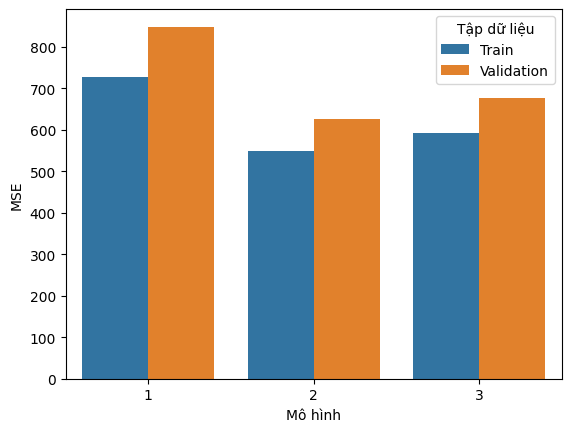

In [468]:
MSE_all = pd.DataFrame({
    'Mô hình' : [1, 1, 2, 2, 3, 3],
    'MSE' : [MSE_train_1, MSE_val_1, MSE_train_2, MSE_val_2, MSE_train_3, MSE_val_3],
    'Tập dữ liệu' : ['Train', 'Validation', 'Train', 'Validation', 'Train', 'Validation']
})

sns.barplot(data=MSE_all, x="Mô hình", y="MSE", hue="Tập dữ liệu")
plt.show()


Mô hình thứ hai thể hiện tốt nhất khi so sánh tương quan giữa hai mô hình còn lại, nên ta sẽ lựa chọn mô hình này

In [469]:
# Decision

X_poly_test = poly_features.fit_transform(X_test)
y2_predict_test = LR_model2.predict(X_poly_test)
MSE_test_LR = mean_squared_error(y2_predict_test, y_test)

prop_LR = np.sum(np.abs(y2_predict_test - np.array(y_test)) < 7) / len(y_test)


best_LR_model = {
    "Model" : LR_model2,
    "MSE_test" : MSE_test_LR,
    "Less_than_5mi_prop" : prop_LR
}


### 3.2 Rừng ngẫu nhiên 

In [470]:
ET_model1 = RandomForestRegressor(min_samples_split=7)

In [471]:
ET_model2 = XGBRegressor(max_depth=5)

In [472]:
ET_model1.fit(X_train, y_train)

RandomForestRegressor(min_samples_split=7)

In [473]:
ET_model2.fit(X_train, y_train)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [474]:
y1_pred_train = ET_model1.predict(X_train)
y2_pred_train = ET_model2.predict(X_train)

y1_pred_val = ET_model1.predict(X_val)
y2_pred_val = ET_model2.predict(X_val)

MSE_train1 = mean_squared_error(y1_pred_train, y_train)
MSE_train2 = mean_squared_error(y2_pred_train, y_train)

MSE_val1 = mean_squared_error(y1_pred_val, y_val)
MSE_val2 = mean_squared_error(y2_pred_val, y_val)


In [475]:
MSE_train1, MSE_train2

(114.4616061036983, 142.8407613853081)

In [476]:
MSE_val1, MSE_val2

(228.8976909816492, 210.42863637024192)

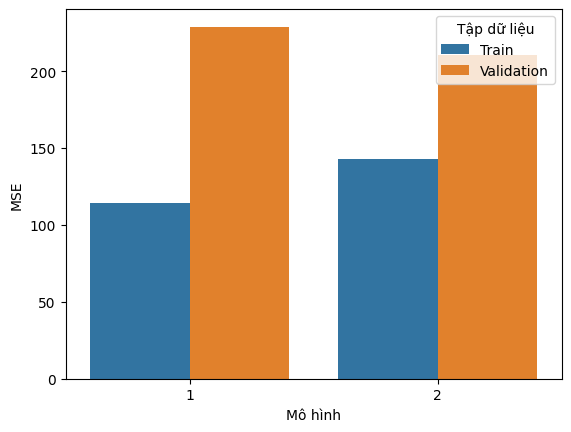

In [477]:
MSE_all = pd.DataFrame({
    'Mô hình' : [1, 1, 2, 2],
    'MSE' : [MSE_train1, MSE_val1, MSE_train2, MSE_val2],
    'Tập dữ liệu' : ['Train', 'Validation', 'Train', 'Validation']
})

sns.barplot(data=MSE_all, x="Mô hình", y="MSE", hue="Tập dữ liệu")
plt.show()

In [478]:
# Decision

y2_pred_test = ET_model2.predict(X_test)
MSE_test_ET = mean_squared_error(y2_pred_test, y_test)

prop_ET = np.sum(np.abs(y2_pred_test - np.array(y_test)) < 7) / len(y_test)


best_ET_model = {
    "Model" : ET_model2,
    "MSE_test" : MSE_test_ET,
    "Less_than_5mi_prop" : prop_ET
}

### 3.3 Mạng Neural

In [479]:
model = keras.Sequential([
      layers.InputLayer(input_shape=(X_train.shape[1]), name="Input-layer"),
      layers.Dense(32, activation='relu', name="layer-1"),
      layers.Dense(64, activation='relu', name="layer-2"),
      layers.Dense(128, activation='relu', name="layer-3"),
      layers.Dense(64, activation='relu', name="layer-4"),
      layers.Dense(32, activation='relu', name="layer-5"),
      layers.Dense(16, activation='relu', name="layer-6"),
      layers.Dense(8, activation='relu', name="layer-7"),
      layers.Dense(1, name='Output-layer')
  ])

model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

model.summary()



Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer-1 (Dense)             (None, 32)                224       
                                                                 
 layer-2 (Dense)             (None, 64)                2112      
                                                                 
 layer-3 (Dense)             (None, 128)               8320      
                                                                 
 layer-4 (Dense)             (None, 64)                8256      
                                                                 
 layer-5 (Dense)             (None, 32)                2080      
                                                                 
 layer-6 (Dense)             (None, 16)                528       
                                                                 
 layer-7 (Dense)             (None, 8)               

In [480]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=60)


Epoch 1/60
278/278 [==============================] - 2s 3ms/step - loss: 882.5154 - val_loss: 788.3773
Epoch 2/60
278/278 [==============================] - 1s 3ms/step - loss: 632.5394 - val_loss: 641.2475
Epoch 3/60
278/278 [==============================] - 1s 3ms/step - loss: 493.7211 - val_loss: 447.1750
Epoch 4/60
278/278 [==============================] - 1s 3ms/step - loss: 426.0186 - val_loss: 384.6824
Epoch 5/60
278/278 [==============================] - 1s 3ms/step - loss: 410.7444 - val_loss: 387.9943
Epoch 6/60
278/278 [==============================] - 1s 3ms/step - loss: 400.5057 - val_loss: 353.0154
Epoch 7/60
278/278 [==============================] - 1s 3ms/step - loss: 393.8939 - val_loss: 355.7844
Epoch 8/60
278/278 [==============================] - 1s 3ms/step - loss: 390.2451 - val_loss: 365.2855
Epoch 9/60
278/278 [==============================] - 1s 3ms/step - loss: 385.9138 - val_loss: 355.2425
Epoch 10/60
278/278 [==============================] - 1s 3ms/st

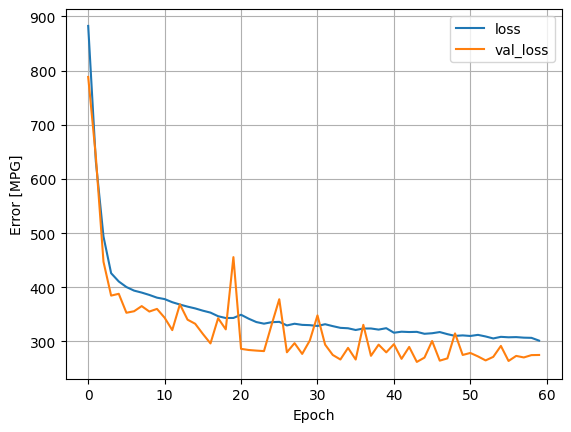

In [481]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error [MPG]')
plt.legend()
plt.grid(True)


In [482]:
# Decision

y_pred = model.predict(X_test)
MSE_test_DNN = mean_squared_error(y_pred, y_test)

prop_DNN = np.sum(np.abs(y_pred.ravel() - np.array(y_test)) < 7) / len(y_test)


best_DNN_model = {
    "Model" : model,
    "MSE_test" : MSE_test_DNN,
    "Less_than_5mi_prop" : prop_DNN
}

35/35 [==============================] - 0s 2ms/step


In [483]:
y_pred.shape

(1112, 1)

In [484]:
best_LR_model

{'Model': SGDRegressor(eta0=0.1, max_iter=150, penalty=None),
 'MSE_test': 629.8543311945987,
 'Less_than_5mi_prop': 0.35701438848920863}

In [485]:
best_ET_model

{'Model': XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...),
 'MSE_test': 286.4652167093918,
 'Less_than_5mi_prop': 0.6474820143884892}

In [486]:
best_DNN_model

{'Model': <keras.engine.sequential.Sequential at 0x7f5092b4ce50>,
 'MSE_test': 363.7987466972006,
 'Less_than_5mi_prop': 0.5674460431654677}

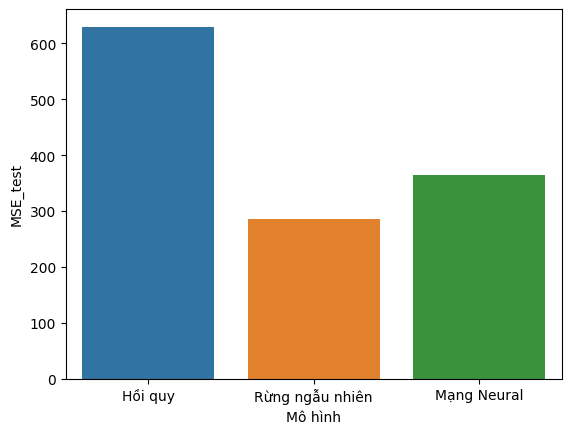

In [487]:
MSE_all = pd.DataFrame({
    'Mô hình' : ["Hồi quy", "Rừng ngẫu nhiên", "Mạng Neural"],
    'MSE_test' : [best_LR_model['MSE_test'], best_ET_model['MSE_test'], best_DNN_model['MSE_test']],
})

sns.barplot(data=MSE_all, x="Mô hình", y="MSE_test")
plt.show()

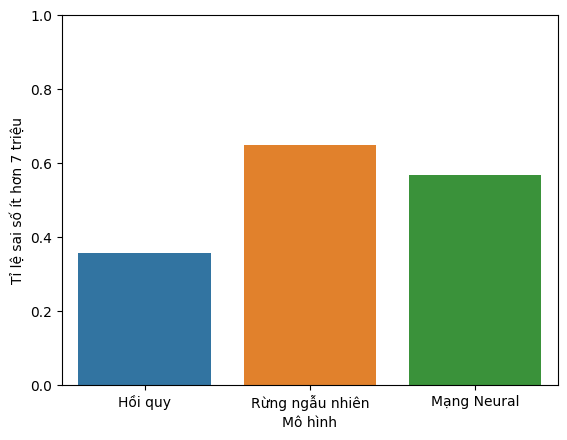

In [488]:
MSE_all = pd.DataFrame({
    'Mô hình' : ["Hồi quy", "Rừng ngẫu nhiên", "Mạng Neural"],
    'Tỉ lệ sai số ít hơn 7 triệu' : [best_LR_model['Less_than_5mi_prop'], best_ET_model['Less_than_5mi_prop']\
        , best_DNN_model['Less_than_5mi_prop']],
})

sns.barplot(data=MSE_all, x="Mô hình", y="Tỉ lệ sai số ít hơn 7 triệu")
plt.ylim((0, 1))
plt.show()

In [489]:
# Final decision

last_model = best_ET_model['Model']

predict_system = {
    "model" : last_model,
    "le_tinh_trg" : le_tinh_trg,
    "le_dung_tich" : le_dung_tich,
    "le_dong_xe" : le_dong_xe,
    "le_loai_xe" : le_loai_xe,
    "cols" : cols
}

In [490]:
pickle.dump(predict_system, open(SAVE_PATH, 'wb'))


In [491]:
# x = np.array([[3, 'Đã sử dụng', '100 - 175 cc', 'Vision', 15000, 'Tay ga']])

# x[:,1] = le_tinh_trg.transform(x[:,1])
# x[:,2] = le_dung_tich.transform(x[:,2])
# x[:,3] = le_dong_xe.transform(x[:,3])
# x[:,5] = le_loai_xe.transform(x[:,5])

# x = x.astype(float)


# for i in range(len(x[0])):
#     x[:,i] = (x[:,i] - cols[i][0]) / (cols[i][1] - cols[i][2])

# x



In [492]:
# int(last_model.predict(x) * 1e6)

In [493]:
# cols